### Importing necessary libraries

In [9]:
%pip install imblearn

import numpy as np
import plotly.io as pio
import pandas as pd
import re
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, hinge_loss, precision_score, recall_score )
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import joblib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Step 1: Data Collection

In [3]:
# Loading the dataset
data = pd.read_csv('C:\\Users\\bchai\\OneDrive\\Desktop\\Mini Projects\\Y\\Natural-Disaster-Prediction-Using-Machine-Learning-main\\Natural-Disaster-Prediction-Using-Machine-Learning-main\\natural_disasters_dataset.csv')

# Displaying information about the Dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16126 entries, 0 to 16125
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        16126 non-null  int64  
 1   Seq                         16126 non-null  int64  
 2   Glide                       1581 non-null   object 
 3   Disaster Group              16126 non-null  object 
 4   Disaster Subgroup           16126 non-null  object 
 5   Disaster Type               16126 non-null  object 
 6   Disaster Subtype            13016 non-null  object 
 7   Disaster Subsubtype         1077 non-null   object 
 8   Event Name                  3861 non-null   object 
 9   Country                     16126 non-null  object 
 10  ISO                         16126 non-null  object 
 11  Region                      16126 non-null  object 
 12  Continent                   16126 non-null  object 
 13  Location                    143

In [4]:
print(data.head(10))

   Year   Seq Glide Disaster Group Disaster Subgroup        Disaster Type  \
0  1900  9002   NaN        Natural    Climatological              Drought   
1  1900  9001   NaN        Natural    Climatological              Drought   
2  1902    12   NaN        Natural       Geophysical           Earthquake   
3  1902     3   NaN        Natural       Geophysical    Volcanic activity   
4  1902    10   NaN        Natural       Geophysical    Volcanic activity   
5  1903     6   NaN        Natural       Geophysical  Mass movement (dry)   
6  1903    12   NaN        Natural       Geophysical    Volcanic activity   
7  1904     3   NaN        Natural    Meteorological                Storm   
8  1905     5   NaN        Natural       Geophysical  Mass movement (dry)   
9  1905     3   NaN        Natural       Geophysical           Earthquake   

   Disaster Subtype Disaster Subsubtype      Event Name        Country  ...  \
0           Drought                 NaN             NaN     Cabo Verde  .

### EDA before Preprocessing the Data

#### i. Bar Plot for "Frequency of Disaster Types by Continent"

In [5]:
import plotly.express as px
import pandas as pd

# Grouping the data by 'Continent' and 'Disaster Type' and counting occurrences
disaster_counts = data.groupby(['Continent', 'Disaster Type']).size().reset_index(name='Count')

# Creating an interactive stacked bar chart
fig = px.bar(
    disaster_counts, 
    x="Continent", 
    y="Count", 
    color="Disaster Type", 
    title="Frequency of Disaster Types by Continent",
    labels={"Count": "Frequency"},
    barmode="stack"
)

# Display the interactive plot
fig.show()


#### ii. Horizontal Bar Chart for "Distribution of Disaster Types"

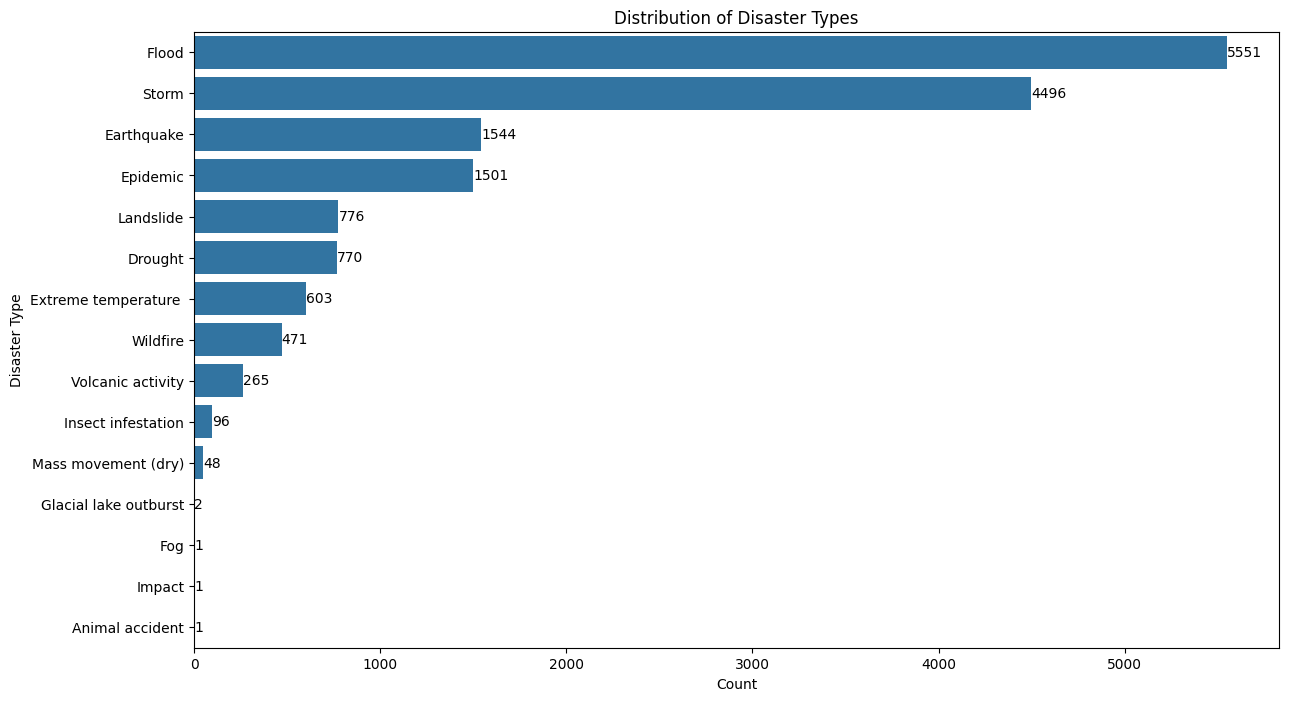

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 8))
disaster_type_counts = data['Disaster Type'].value_counts().sort_values(ascending=False)

sns.barplot(x=disaster_type_counts, y=disaster_type_counts.index)

# Displaying the frequency count
for index, value in enumerate(disaster_type_counts):
    plt.text(value, index, str(value), va='center', fontsize=10, color='black', ha='left')

# Setting x and y labels and Title for the plot
plt.title('Distribution of Disaster Types')
plt.xlabel('Count')
plt.ylabel('Disaster Type')
plt.show()

#### iii. Correlation Analysis - HeatMap

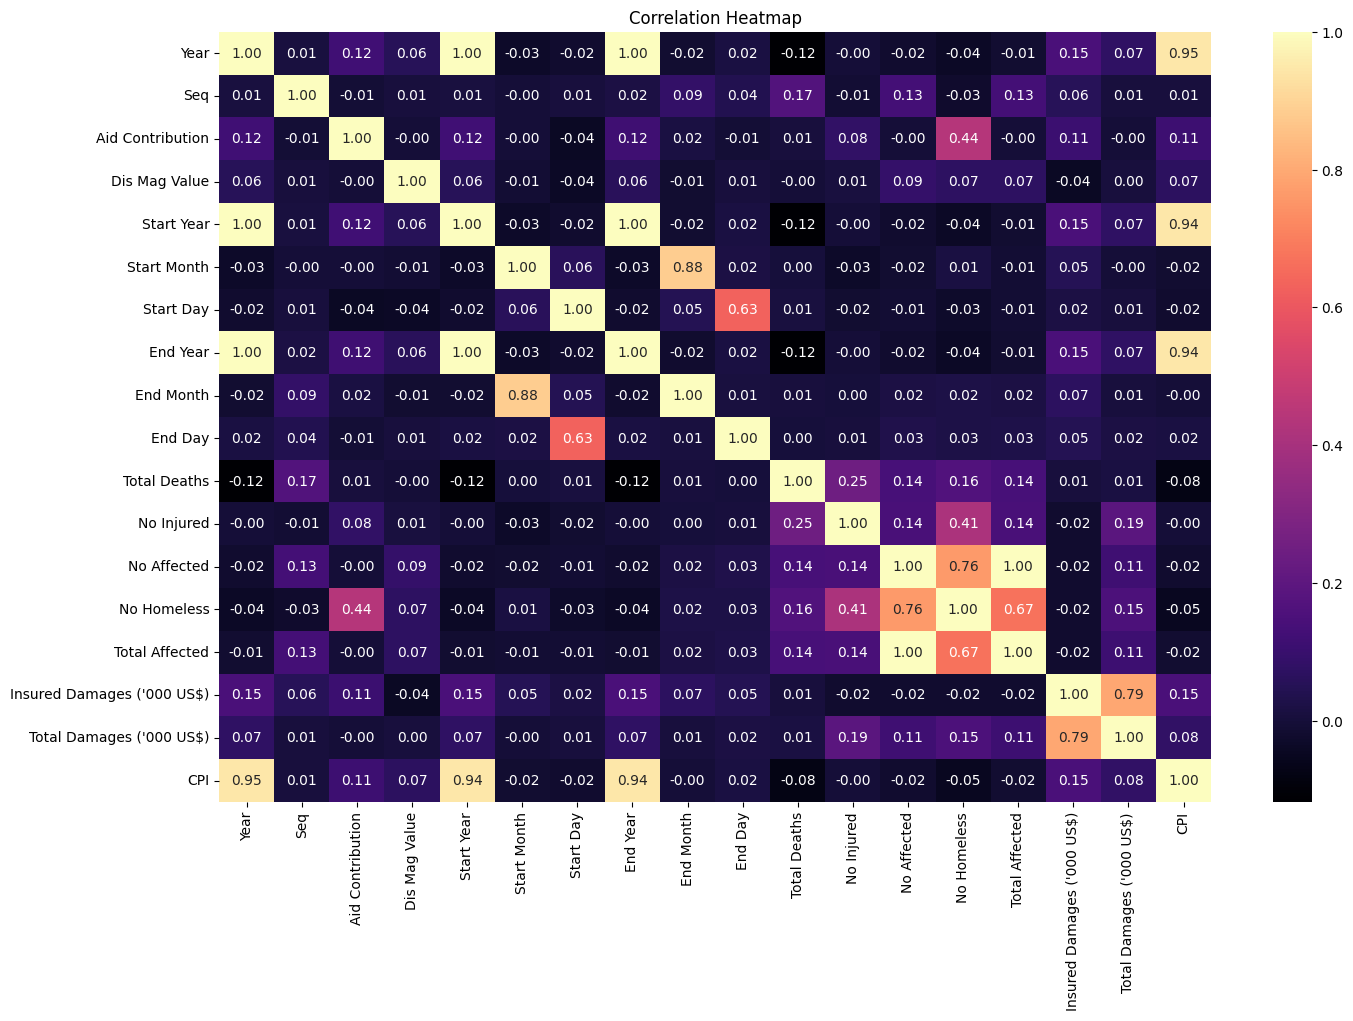

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_data = data.select_dtypes(include=[np.number])

plt.figure(figsize=(16, 10))
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt='.2f')

plt.title('Correlation Heatmap')
plt.show()


#### iv. Time series analysis of top 5 disasters

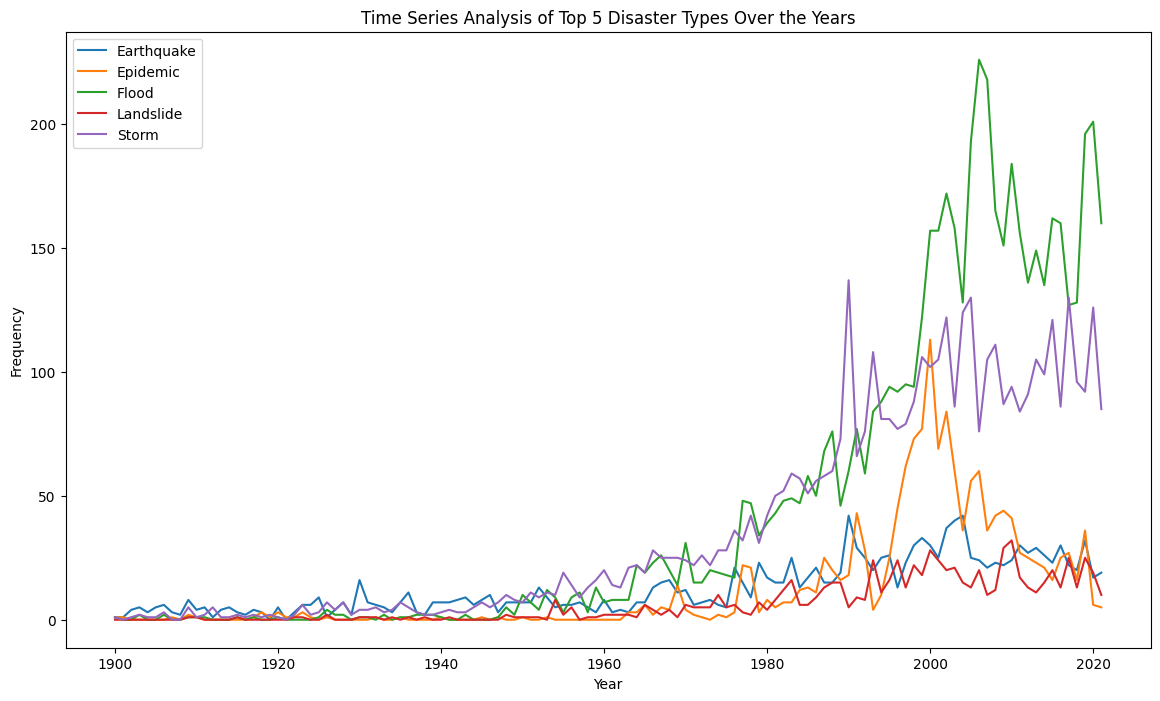

In [11]:
import seaborn as sns

# Time series analysis for the count of each top 5 disaster types over the years
plt.figure(figsize=(14, 8))

# Filter the data for the top 5 disaster types
top_disaster_types = data['Disaster Type'].value_counts().nlargest(5).index
filtered_data = data[data['Disaster Type'].isin(top_disaster_types)]

# Group the filtered data by 'Start Year' and 'Disaster Type' and calculate the count
disaster_type_counts = filtered_data.groupby(['Start Year', 'Disaster Type']).size().unstack(fill_value=0)

# Plot time series for each top 5 disaster type
for disaster_type in disaster_type_counts.columns:
    plt.plot(disaster_type_counts.index, disaster_type_counts[disaster_type], label=disaster_type)

# Setting labels and title for the plot
plt.title('Time Series Analysis of Top 5 Disaster Types Over the Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend()
plt.show()



## Step 2: Data Preprocessing

### i. Checking for Missing values

In [12]:
# Checking for Missing values
print("Null values:")
print(data.isnull().sum())

Null values:
Year                              0
Seq                               0
Glide                         14545
Disaster Group                    0
Disaster Subgroup                 0
Disaster Type                     0
Disaster Subtype               3110
Disaster Subsubtype           15049
Event Name                    12265
Country                           0
ISO                               0
Region                            0
Continent                         0
Location                       1792
Origin                        12332
Associated Dis                12778
Associated Dis2               15419
OFDA Response                 14432
Appeal                        13557
Declaration                   12870
Aid Contribution              15449
Dis Mag Value                 11180
Dis Mag Scale                  1190
Latitude                      13397
Longitude                     13394
Local Time                    15023
River Basin                   14839
Start Year     

### ii. Handling Missing values

In [13]:
data.replace('nan', np.nan, inplace=True)

#### Imputing the Missing Numerical values with Mean and Categorical values with Mode

In [15]:
import numpy as np
from sklearn.impute import SimpleImputer

# Impute numeric columns using the mean strategy
numerical_cols = data.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

# Impute categorical columns using the most frequent strategy
categorical_cols = data.select_dtypes(include='object').columns
imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = imputer.fit_transform(data[categorical_cols])



In [16]:
print(data.isnull().sum())

Year                          0
Seq                           0
Glide                         0
Disaster Group                0
Disaster Subgroup             0
Disaster Type                 0
Disaster Subtype              0
Disaster Subsubtype           0
Event Name                    0
Country                       0
ISO                           0
Region                        0
Continent                     0
Location                      0
Origin                        0
Associated Dis                0
Associated Dis2               0
OFDA Response                 0
Appeal                        0
Declaration                   0
Aid Contribution              0
Dis Mag Value                 0
Dis Mag Scale                 0
Latitude                      0
Longitude                     0
Local Time                    0
River Basin                   0
Start Year                    0
Start Month                   0
Start Day                     0
End Year                      0
End Mont

### iii. Encoding Categorical variables 

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])


### EDA after Preprocessing the Data

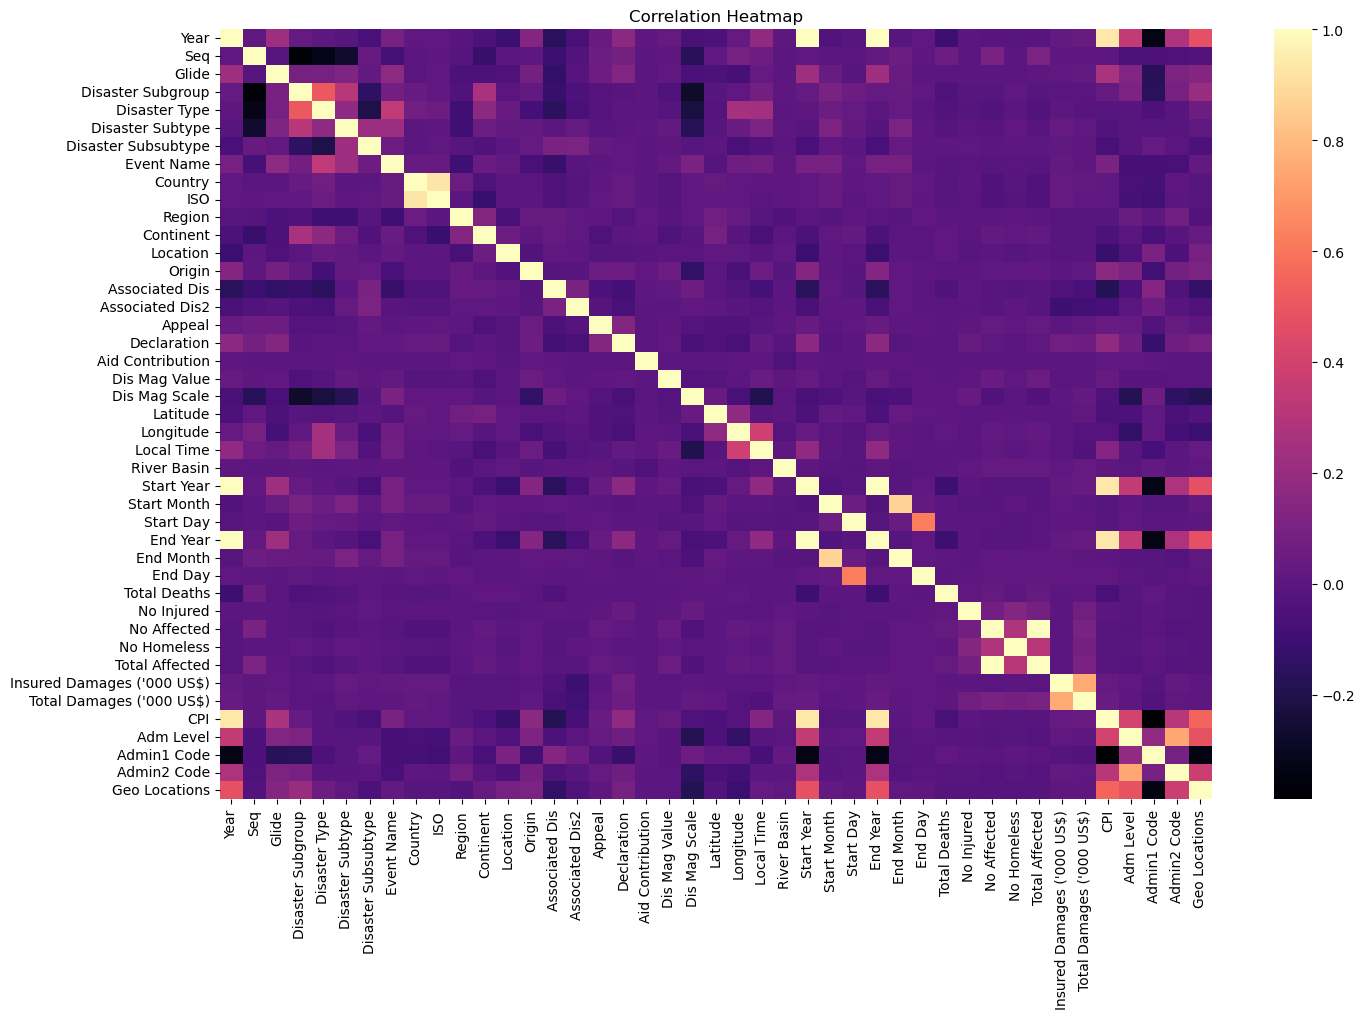

In [13]:
# Identify and remove single-valued columns
non_single_valued_columns = data.columns[data.nunique() > 1]
filtered_data = data[non_single_valued_columns]

# Visualizing correlation HeatMap for Numerical features
plt.figure(figsize=(16, 10))
correlation_matrix = filtered_data.corr()
sns.heatmap(correlation_matrix, annot= False, cmap='magma')

# Setting Title for the plot
plt.title('Correlation Heatmap')
plt.show()

## Step 3: Feature Selection

#### Based on Mutal Information and Domain knowledge we selected the Features

In [20]:
from sklearn.feature_selection import mutual_info_classif

# Feature selection using mutual information
X = data.drop('Disaster Type', axis=1)  
y = data['Disaster Type']

# Based on Domain Knowledge we are including 'Year' feature
X['Year'] = X['Year'].astype(float)  
mutual_info = mutual_info_classif(X, y)
feature_importance = pd.Series(mutual_info, index=X.columns)

# Selecting top 10 features
selected_features = feature_importance.nlargest(10).index  

if 'Year' not in selected_features:
    selected_features = selected_features.append(pd.Index(['Year']))

# Printing the selected features
X_selected = X[selected_features]
print(X_selected.columns)

Index(['Disaster Subtype', 'Disaster Subgroup', 'Dis Mag Scale',
       'Dis Mag Value', 'Event Name', 'Country', 'ISO', 'Seq', 'Longitude',
       'Latitude', 'Year'],
      dtype='object')


In [21]:
# Loading the selected features into a new CSV file
selected_features = [
    'Year',  'Dis Mag Scale','Dis Mag Value', 'Country', 'Longitude', 'Latitude', 'Disaster Type'
]

data_selected = data[selected_features]

In [22]:
# Save the new CSV file as preprocessed_data.csv
data_selected.to_csv('preprocessed_data.csv', index=False)

In [23]:
# Load the preprocessed_data.csv file
data_selected = pd.read_csv('preprocessed_data.csv')

In [24]:
data_selected.head(10)

,Year,Dis Mag Scale,Dis Mag Value,Country,Longitude,Latitude,Disaster Type
0,1900.0,0,47350.380307,31,2376,1242,1
1,1900.0,0,47350.380307,89,2376,1242,1
2,1902.0,2,8.000000,80,482,662,2
3,1902.0,0,47350.380307,80,2376,1242,13
4,1902.0,0,47350.380307,80,2376,1242,13
5,1903.0,0,47350.380307,34,2376,1242,11
6,1903.0,0,47350.380307,42,2376,1242,13
7,1904.0,1,47350.380307,15,2376,1242,12
8,1905.0,0,47350.380307,34,2376,1242,11
9,1905.0,2,8.000000,89,2151,1329,2


In [25]:
# Checking for missing values in the new csv file
print(data_selected.isnull().sum())

Year             0
Dis Mag Scale    0
Dis Mag Value    0
Country          0
Longitude        0
Latitude         0
Disaster Type    0
dtype: int64


## Step 4: Model Development

### i. Random Forest

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Separating feature set and target variable
X = data_selected.drop('Disaster Type', axis=1)
y = data_selected['Disaster Type']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=50,  # Number of trees in the forest
    max_depth=None,    # Maximum depth of the tree
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node
    random_state=42
)

# Model Fitting
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Evaluation of the model
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred))

Random Forest Classifier:
Accuracy: 0.8316800991940484


### ii. Support Vector Machine

In [31]:
from sklearn.svm import SVC

# Separating feature set and target variable
X = data_selected.drop('Disaster Type', axis=1)
y = data_selected['Disaster Type']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Support Vector Machine model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

# Evaluate the SVM model
print("Support Vector Machine (SVM):")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Support Vector Machine (SVM):
Accuracy: 0.3716676999380037


### iii. K- Nearest Neighbor

In [33]:
from sklearn.neighbors import KNeighborsClassifier

# Separating feature set and target variable
X = data_selected.drop('Disaster Type', axis=1)
y = data_selected['Disaster Type']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the K-Nearest Neighbors model
knn_model = KNeighborsClassifier(
    n_neighbors=5,  # Number of neighbors to use
    weights='uniform',  # Weight function used in prediction
    algorithm='auto',  # Algorithm used to compute the nearest neighbors
)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

# Evaluation of the KNN model
print("K-Nearest Neighbors (KNN):")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

K-Nearest Neighbors (KNN):
Accuracy: 0.689398636081835


### iv. Navie Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB

# Separate feature set and target variable
X = data_selected.drop('Disaster Type', axis=1)
y = data_selected['Disaster Type']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

# Evaluation of the Naive Bayes model
print("Naive Bayes:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes:
Accuracy: 0.14290142591444513


## Step 5: Model Evaluation

In [37]:
# Evaluating the performance of Random Forest
print("Random Forest Classifier Evaluation Metrics:")
# Evaluating the performance of Random Forest
print("Random Forest Classifier Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall (Sensitivity):", recall_score(y_test, y_pred, average='weighted'))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("\n")

# Evaluating the performance of SVM
print("Support Vector Machine (SVM)-Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_svm, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("\n")

# Evaluating the performance of K-NN
print("K-Nearest Neighbor (K-NN)-Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred_knn, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_knn, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_knn, average='weighted'))
print("\n")

# Evaluating the performance of Navie Bayes
print("Navie Bayes-Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_nb, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("\n")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall (Sensitivity):", recall_score(y_test, y_pred, average='weighted'))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("\n")

# Evaluating the performance of SVM
print("Support Vector Machine (SVM)-Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_svm, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("\n")

# Evaluating the performance of K-NN
print("K-Nearest Neighbor (K-NN)-Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred_knn, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_knn, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_knn, average='weighted'))
print("\n")

# Evaluating the performance of Navie Bayes
print("Navie Bayes-Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_nb, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("\n")


Random Forest Classifier Evaluation Metrics:
Random Forest Classifier Evaluation Metrics:


NameError: name 'f1_score' is not defined

## Step 6: Tuning

#### As some of our models did not perform well, we checking whether our data is balaned or not

In [25]:
# Checking the class distribution
print(data_selected['Disaster Type'].value_counts())

5     5551
12    4496
2     1544
3     1501
10     776
1      770
4      603
14     471
13     265
9       96
11      48
7        2
6        1
8        1
0        1
Name: Disaster Type, dtype: int64


#### Our data is not balanced, so to balance our data we are using Random Oversampler Technique

In [26]:
# Separating feature set and target variable
X = data_selected.drop('Disaster Type', axis=1)
y = data_selected['Disaster Type']

# Initializing the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Fitting and applying the oversampling
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [27]:
# Checking the new class distribution
print(pd.Series(y_resampled).value_counts())

1     5551
2     5551
13    5551
11    5551
12    5551
5     5551
3     5551
10    5551
14    5551
4     5551
6     5551
9     5551
8     5551
0     5551
7     5551
Name: Disaster Type, dtype: int64


#### Now as we have a balanced data, we are processing from step 4 again

In [28]:
# Splitting the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardizing/Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

# Training the Support Vector Machine (SVM)
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

# Training the K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

# Training the Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

y_pred_nb = nb_model.predict(X_test_scaled)

In [29]:
# Evaluating the performance of Random Forest
print("Random Forest Classifier Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_rf, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("\n")

# Evaluating the performance of SVM
print("Support Vector Machine (SVM)-Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_svm, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("\n")

# Evaluating the performance of K-NN
print("K-Nearest Neighbor (K-NN)-Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred_knn, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_knn, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_knn, average='weighted'))
print("\n")

# Evaluating the performance of Navie Bayes
print("Navie Bayes-Evaluation Metrics:")
print("F1 Score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_nb, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("\n")

Random Forest Classifier Evaluation Metrics:
F1 Score: 0.9519389979386549
Accuracy: 0.953822134150003
Recall (Sensitivity): 0.953822134150003
Precision: 0.9551815103634058


Support Vector Machine (SVM)-Evaluation Metrics:
F1 Score: 0.633872977472952
Accuracy: 0.6500330270822074
Recall (Sensitivity): 0.6500330270822074
Precision: 0.6828630625480667


K-Nearest Neighbor (K-NN)-Evaluation Metrics:
F1 Score: 0.9251906691254912
Accuracy: 0.9306431273644389
Recall (Sensitivity): 0.9306431273644389
Precision: 0.9316988724025791


Navie Bayes-Evaluation Metrics:
F1 Score: 0.6297211670429899
Accuracy: 0.6532156368221942
Recall (Sensitivity): 0.6532156368221942
Precision: 0.7167261979602237




## Performing Ensemble Techniques

### Hard voting Ensemble combining 4 models

In [30]:
# Combining individual models to form a Ensemble Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
nb_model = GaussianNB()

# Creating a hard voting classifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('svm', svm_model),
    ('knn', knn_model),
    ('nb', nb_model)
], voting='hard')

# Fitting the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

y_pred_ensemble = ensemble_model.predict(X_test_scaled)

# Evaluate the ensemble model
print("\nEnsemble Model (Hard Voting):")
print("F1 Score:", f1_score(y_test, y_pred_ensemble, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_ensemble, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_ensemble, average='weighted'))


Ensemble Model (Hard Voting):
F1 Score: 0.918754273334802
Accuracy: 0.9228967753557917
Recall (Sensitivity): 0.9228967753557917
Precision: 0.9292699366964609


### Soft voting ensemble combining 4 models

In [31]:
# Combining individual models with probability estimates to form an Ensemble Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
nb_model = GaussianNB()

# Creating a soft voting classifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('svm', svm_model),
    ('knn', knn_model),
    ('nb', nb_model)
], voting='soft')

# Fitting the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

y_pred_ensemble = ensemble_model.predict(X_test_scaled)

# Evaluate the ensemble model
print("\nEnsemble Model (Soft Voting):")
print("F1 Score:", f1_score(y_test, y_pred_ensemble, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_ensemble, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_ensemble, average='weighted'))


Ensemble Model (Soft Voting):
F1 Score: 0.9352540236961946
Accuracy: 0.9392301687383655
Recall (Sensitivity): 0.9392301687383655
Precision: 0.9433715392610226


### Visualization of Performance metrics using Grouped Bar chart

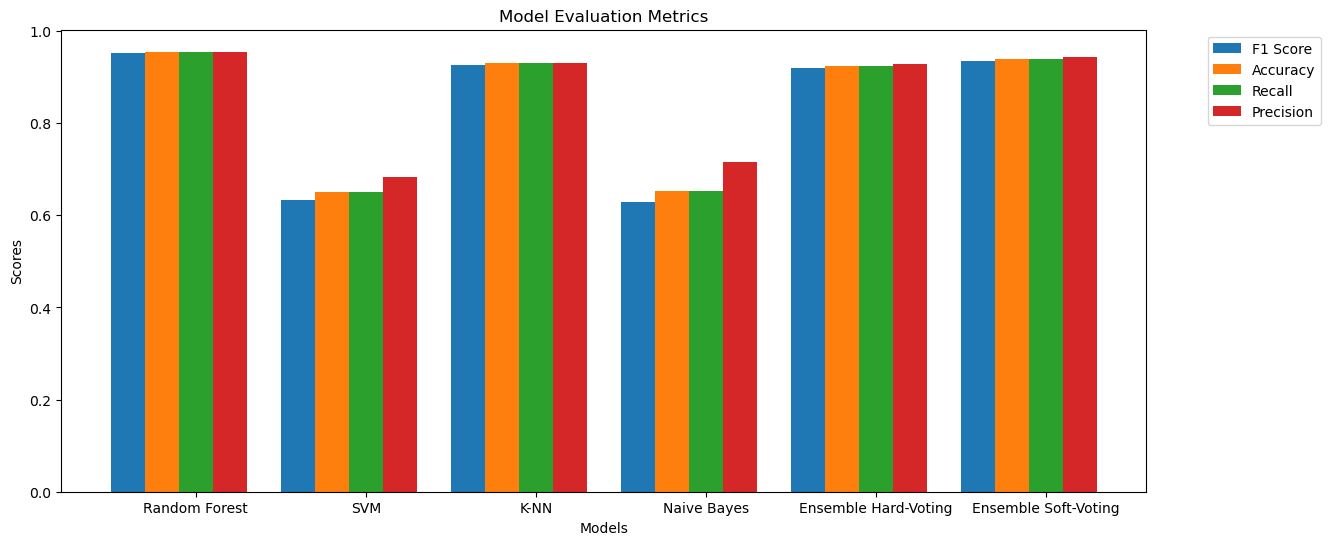

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Models and their respective perfromance metrics
models = ['Random Forest', 'SVM', 'K-NN', 'Naive Bayes', 'Ensemble Hard-Voting', 'Ensemble Soft-Voting']
f1_scores = [0.9519, 0.6340, 0.9258, 0.6297, 0.91947, 0.93508 ]
accuracies = [0.9538, 0.6501, 0.9313, 0.6532, 0.92361, 0.93905 ]
recalls = [0.9538, 0.6501, 0.9313, 0.6532, 0.92361, 0.93905]
precisions = [0.9552, 0.6831, 0.9316, 0.7167, 0.92917, 0.94320]

# Grouped Bar chart
bar_width = 0.2
index = np.arange(len(models))

# Plotting the chart
fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(index - bar_width, f1_scores, bar_width, label='F1 Score')
bar2 = ax.bar(index, accuracies, bar_width, label='Accuracy')
bar3 = ax.bar(index + bar_width, recalls, bar_width, label='Recall')
bar4 = ax.bar(index + 2 * bar_width, precisions, bar_width, label='Precision')

# Settign up the Legend and Title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(models)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


#### * After visualizing the Grouped bar chart, we consider Random Forest to be our best Model <br> * We wanted to assess the generaliziability and performance of our model further. <br> * To achieve this we have done HyperParameter Tuning and Cross validation on our best model. <br>

In [33]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Performing Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Getting the best parameters
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Print the best parameters
print("Best Hyperparameters for Random Forest:", best_params)

Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [34]:
# Loading Cross-Validation results into a Data frame
cv_results = pd.DataFrame(grid_search.cv_results_)
print("\nCross-Validation Results:")
print(cv_results[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']])


Cross-Validation Results:
   param_n_estimators param_max_depth param_min_samples_split  \
0                  50            None                       2   
1                 100            None                       2   
2                 150            None                       2   
3                  50            None                       5   
4                 100            None                       5   
..                ...             ...                     ...   
76                100              20                       5   
77                150              20                       5   
78                 50              20                      10   
79                100              20                      10   
80                150              20                      10   

   param_min_samples_leaf  mean_test_score  
0                       1         0.948733  
1                       1         0.948928  
2                       1         0.948793  
3           

#### Perfroming evalution metrics again on the Best model after Hyperparameter Tuning

In [35]:
# Evaluate the best model on the test set
y_pred_rf_tuned = best_rf_model.predict(X_test_scaled)

# Model Evaluation after Hyperparameter Tuning
print("Random Forest Classifier after Hyperparameter Tuning:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("F1 Score:", f1_score(y_test, y_pred_rf_tuned, average='weighted'))
print("Recall (Sensitivity):", recall_score(y_test, y_pred_rf_tuned, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_rf_tuned, average='weighted'))

Random Forest Classifier after Hyperparameter Tuning:
Accuracy: 0.953822134150003
F1 Score: 0.9519389979386549
Recall (Sensitivity): 0.953822134150003
Precision: 0.9551815103634058


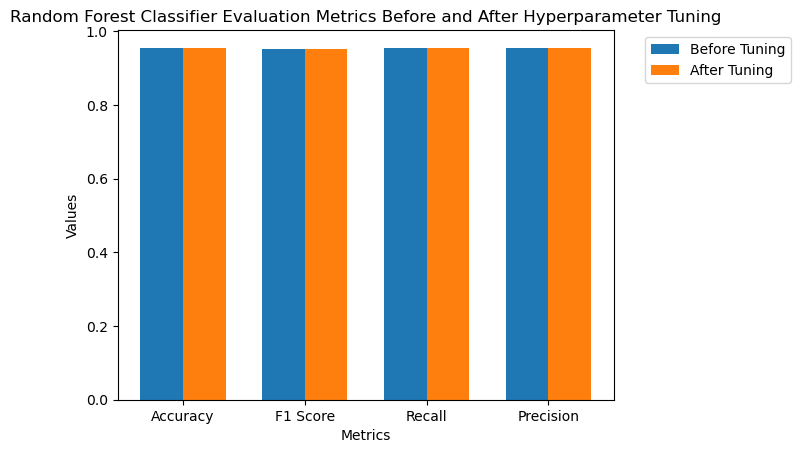

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics before hyperparameter tuning
metrics_before_tuning = {
    'Accuracy': 0.953822134150003,
    'F1 Score': 0.9519389979386549,
    'Recall': 0.953822134150003,
    'Precision': 0.9551815103634058
}

# Metrics after hyperparameter tuning
metrics_after_tuning = {
    'Accuracy': 0.953822134150003,
    'F1 Score': 0.9519389979386549,
    'Recall': 0.953822134150003,
    'Precision': 0.9551815103634058
}

metrics_names = list(metrics_before_tuning.keys())
values_before_tuning = list(metrics_before_tuning.values())
values_after_tuning = list(metrics_after_tuning.values())

bar_width = 0.35
index = np.arange(len(metrics_names))

fig, ax = plt.subplots()
bar1 = ax.bar(index, values_before_tuning, bar_width, label='Before Tuning')
bar2 = ax.bar(index + bar_width, values_after_tuning, bar_width, label='After Tuning')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Random Forest Classifier Evaluation Metrics Before and After Hyperparameter Tuning')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics_names)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


#### After visualzing the above graph we can observe that there is no change in the performance metrics of our best model, before and after hyper parameter tuning

#### Hence, we conclude that Our Best Model, Random forest's best performance metrics are <br>
<b>Accuracy =  0.953822134150003<br>
    F1 Score = 0.9519389979386549<br>
    Recall =  0.953822134150003<br>
    Precision = 0.9551815103634058</b>

## Step 7: Saving the Model

In [37]:
# Fitting the Random Forest Classifier
rf_model.fit(X_train_scaled, y_train)

# Saving the trained Random Forest model to a file
joblib.dump(rf_model, 'random_forest_model.joblib')

# Evaluating the model
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Classifier:
Accuracy: 0.953822134150003


In [38]:
# Initializing the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Fitting and applying the oversampling
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Saving the oversampler to a file
joblib.dump(oversampler, 'oversampler.joblib')


['oversampler.joblib']